In [1]:
from dataset import *
from model import *
import warnings
warnings.filterwarnings("ignore")

/home/prio/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))  # 0 corresponds to the first GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Working on device: ", device)

TRAIN_SIZE = 1200
TEST_SIZE = 10

TRAIN = True

True
NVIDIA GeForce RTX 3050 Ti Laptop GPU
Working on device:  cuda:0


In [3]:
train_dataset, test_dataset = prepare_dataset(TRAIN_SIZE,TEST_SIZE,batch_size=8)
train_loader, test_loader = prepare_dataloader(train_dataset, test_dataset)

Dataset loaded successfully
Data loader prepared successfully


### old code

In [4]:
# '''
# https://medium.com/analytics-vidhya/unet-implementation-in-pytorch-idiot-developer-da40d955f201
# '''

# class conv_block(torch.nn.Module):
#     def __init__(self, in_c, out_c):
#         super().__init__()
#         self.conv1 = torch.nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
#         self.bn1 = torch.nn.BatchNorm2d(out_c)        
#         self.conv2 = torch.nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
#         self.bn2 = torch.nn.BatchNorm2d(out_c)         
#         self.relu = torch.nn.ReLU()     
        
#     def forward(self, inputs):
#         x = self.conv1(inputs)
#         x = self.bn1(x)
#         x = self.relu(x)        

#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.relu(x)
#         return x
    

# class decoder_block(torch.nn.Module):
#     def __init__(self, in_c, out_c):
#         super().__init__()
#         self.up = torch.nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
#         self.conv = conv_block(out_c+out_c, out_c)     
        
#     def forward(self, inputs, skip):
#         display("shape of inputs",inputs.shape,"shape of skip",skip.shape)  
#         x = self.up(inputs)
#         # x = torch.cat([x, skip], axis=1)
#         display("Concatenation successful",x.shape)
#         x = self.conv(x)
#         return x
    

# class Unet(torch.nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.encoder = VGG_Encoder()


#         ## ----------------- v1 ----------------

#         # ## Bottleneck
#         # self.bottleneck = conv_block(512, 1024)
        
#         # """ Decoder """
#         # self.d1 = decoder_block(1024, 512)
#         # self.d2 = decoder_block(512, 256)
#         # self.d3 = decoder_block(256, 128)
#         # self.d4 = decoder_block(128, 64)

#         ## ----------------- v2 ----------------
#         # """ Decoder """
#         self.d0 = decoder_block(512, 512)
#         self.d1 = decoder_block(512, 256)
#         self.d2 = decoder_block(256, 128)
#         self.d3 = decoder_block(128, 64)
#         self.d4 = decoder_block(64, 32)


#         ## output should be 3 channels image
#         self.out = torch.nn.Conv2d(64, 3, kernel_size=1, padding=0)

#     def forward(self,x):
#         ## Encoder
#         out1, out2, out3, out4 = self.encoder(x)

#         # x = self.d0(x, out4)
#         # x = self.d1(x, out3)
#         # x = self.d2(x, out2)
#         # x = self.d3(x, out1)
#         # x = self.d4(x, x)

#         x = self.d0(out4, out4)
#         x = self.d1(x, out3)
#         x = self.d2(x, out2)
#         x = self.d3(x, out1)
#         x = self.d4(x, out1)

#         return self.out(x)
    
#     # def forward(self, x):
#     #     ## Encoder
#     #     out1, out2, out3, out4 = self.encoder(x)

#     #     ## bottleneck
#     #     out = self.bottleneck(out4)

#     #     ## decoder
#     #     d1 = self.d1(out, out4)
#     #     d2 = self.d2(d1, out3)
#     #     d3 = self.d3(d2, out2)
#     #     d4 = self.d4(d3, out1)
                
        
#     #     out = self.out(d4)
#     #     return out

In [5]:
# model = Unet().to(device)
# model.train()

# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# criterion = torch.nn.MSELoss()

# NUM_EPOCHS = 2

# for epoch in range(NUM_EPOCHS):
#     model.train()
#     running_loss = 0.0

#     for batch in tqdm(train_loader):
         
#         grayscale_X = batch['grayscale_image']
#         X = grayscale_X.repeat(1,3,1,1).to(device)
#         y = batch['image'].to(device)

#         out = model(X)
#         loss = criterion(out, y)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item() * x.size(0)
        
#     epoch_loss = running_loss / len(train_loader)
#     print(f"Epoch {epoch+1} loss: {epoch_loss:.4f}")

-------------------------------------------------------------

In [6]:
if TRAIN:

    model = Unet().to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.MSELoss()

    NUM_EPOCHS = 54

    '''
    Network takes as input a 3-channel lab image and outputs a 2-channel ab image
    '''
    for epoch in tqdm(range(NUM_EPOCHS)):
        model.train()
        running_loss = 0.0

        for batch in train_loader:
            
            X = batch['grayscale_image'].to(device)
            y = batch['image'][:,1:,:,:].to(device) ## take only the ab channels

            out = model(X)
            loss = criterion(out, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X.size(0)
            
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1} loss: {epoch_loss:.4f}")

    torch.save(model.state_dict(), 'unet-1200-2.pth')

  2%|▏         | 1/54 [00:45<40:09, 45.47s/it]

Epoch 1 loss: 0.3303


  4%|▎         | 2/54 [01:30<39:25, 45.50s/it]

Epoch 2 loss: 0.2736


  6%|▌         | 3/54 [02:16<38:44, 45.58s/it]

Epoch 3 loss: 0.2699


  7%|▋         | 4/54 [03:02<38:00, 45.62s/it]

Epoch 4 loss: 0.2652


  9%|▉         | 5/54 [03:48<37:18, 45.68s/it]

Epoch 5 loss: 0.2645


 11%|█         | 6/54 [04:34<36:36, 45.76s/it]

Epoch 6 loss: 0.2611


 13%|█▎        | 7/54 [05:20<35:54, 45.84s/it]

Epoch 7 loss: 0.2599


 15%|█▍        | 8/54 [06:06<35:11, 45.91s/it]

Epoch 8 loss: 0.2578


 17%|█▋        | 9/54 [06:52<34:32, 46.06s/it]

Epoch 9 loss: 0.2544


 19%|█▊        | 10/54 [07:38<33:51, 46.17s/it]

Epoch 10 loss: 0.2541


 20%|██        | 11/54 [08:24<33:04, 46.14s/it]

Epoch 11 loss: 0.2525


 22%|██▏       | 12/54 [09:10<32:15, 46.08s/it]

Epoch 12 loss: 0.2506


 24%|██▍       | 13/54 [09:56<31:28, 46.06s/it]

Epoch 13 loss: 0.2488


 26%|██▌       | 14/54 [10:43<30:44, 46.10s/it]

Epoch 14 loss: 0.2465


 28%|██▊       | 15/54 [11:29<30:03, 46.24s/it]

Epoch 15 loss: 0.2477


 30%|██▉       | 16/54 [12:16<29:18, 46.28s/it]

Epoch 16 loss: 0.2440


 31%|███▏      | 17/54 [13:02<28:37, 46.43s/it]

Epoch 17 loss: 0.2441


 33%|███▎      | 18/54 [13:49<27:51, 46.43s/it]

Epoch 18 loss: 0.2387


 35%|███▌      | 19/54 [14:35<27:05, 46.43s/it]

Epoch 19 loss: 0.2344


 37%|███▋      | 20/54 [15:23<26:28, 46.73s/it]

Epoch 20 loss: 0.2347


 39%|███▉      | 21/54 [16:09<25:40, 46.68s/it]

Epoch 21 loss: 0.2333


 41%|████      | 22/54 [16:56<24:50, 46.58s/it]

Epoch 22 loss: 0.2347


 43%|████▎     | 23/54 [17:42<24:01, 46.51s/it]

Epoch 23 loss: 0.2267


 44%|████▍     | 24/54 [18:28<23:13, 46.44s/it]

Epoch 24 loss: 0.2243


 46%|████▋     | 25/54 [19:14<22:25, 46.38s/it]

Epoch 25 loss: 0.2221


 48%|████▊     | 26/54 [20:01<21:37, 46.35s/it]

Epoch 26 loss: 0.2223


 50%|█████     | 27/54 [20:47<20:52, 46.38s/it]

Epoch 27 loss: 0.2152


 52%|█████▏    | 28/54 [21:34<20:10, 46.57s/it]

Epoch 28 loss: 0.2178


 54%|█████▎    | 29/54 [22:21<19:27, 46.72s/it]

Epoch 29 loss: 0.2129


 56%|█████▌    | 30/54 [23:08<18:44, 46.83s/it]

Epoch 30 loss: 0.2091


 57%|█████▋    | 31/54 [23:55<17:54, 46.73s/it]

Epoch 31 loss: 0.2071


 59%|█████▉    | 32/54 [24:41<17:05, 46.60s/it]

Epoch 32 loss: 0.2016


 61%|██████    | 33/54 [25:27<16:16, 46.49s/it]

Epoch 33 loss: 0.1983


 63%|██████▎   | 34/54 [26:15<15:34, 46.71s/it]

Epoch 34 loss: 0.1978


 65%|██████▍   | 35/54 [27:02<14:53, 47.00s/it]

Epoch 35 loss: 0.1949


 67%|██████▋   | 36/54 [27:51<14:16, 47.58s/it]

Epoch 36 loss: 0.1912


 69%|██████▊   | 37/54 [28:39<13:27, 47.52s/it]

Epoch 37 loss: 0.1861


 70%|███████   | 38/54 [29:25<12:35, 47.25s/it]

Epoch 38 loss: 0.1846


 72%|███████▏  | 39/54 [30:12<11:44, 46.98s/it]

Epoch 39 loss: 0.1861


 74%|███████▍  | 40/54 [30:58<10:55, 46.82s/it]

Epoch 40 loss: 0.1791


 76%|███████▌  | 41/54 [31:44<10:06, 46.68s/it]

Epoch 41 loss: 0.1760


 78%|███████▊  | 42/54 [32:31<09:19, 46.64s/it]

Epoch 42 loss: 0.1739


 80%|███████▉  | 43/54 [33:19<08:37, 47.01s/it]

Epoch 43 loss: 0.1721


 81%|████████▏ | 44/54 [34:05<07:49, 46.92s/it]

Epoch 44 loss: 0.1676


 83%|████████▎ | 45/54 [34:52<07:00, 46.77s/it]

Epoch 45 loss: 0.1629


 85%|████████▌ | 46/54 [35:38<06:13, 46.63s/it]

Epoch 46 loss: 0.1644


 87%|████████▋ | 47/54 [36:24<05:25, 46.53s/it]

Epoch 47 loss: 0.1609


 89%|████████▉ | 48/54 [37:11<04:38, 46.45s/it]

Epoch 48 loss: 0.1619


 91%|█████████ | 49/54 [37:57<03:52, 46.43s/it]

Epoch 49 loss: 0.1559


 93%|█████████▎| 50/54 [38:44<03:05, 46.48s/it]

Epoch 50 loss: 0.1568


 94%|█████████▍| 51/54 [39:30<02:19, 46.52s/it]

Epoch 51 loss: 0.1503


 96%|█████████▋| 52/54 [40:17<01:33, 46.54s/it]

Epoch 52 loss: 0.1498


 98%|█████████▊| 53/54 [41:04<00:46, 46.60s/it]

Epoch 53 loss: 0.1460


100%|██████████| 54/54 [41:51<00:00, 46.51s/it]

Epoch 54 loss: 0.1433


In [7]:
torch.cat([torch.zeros(4,512,32,32),torch.zeros(4,256,32,32)],axis=1).shape

torch.Size([4, 768, 32, 32])

### end

In [8]:
if not TRAIN:
    model = Unet().to(device)
    model.load_state_dict(torch.load('unet-1200-54-skip.pth'))

In [9]:
def plot_both(image1,image2):
    # Create subplots
    plt.figure(figsize=(10, 5))

    # Plot first image
    plt.subplot(1, 2, 1)
    plt.imshow(image1)
    plt.title('Image 1')

    # Plot second image
    plt.subplot(1, 2, 2)
    plt.imshow(image2)
    plt.title('Image 2')

    plt.show()


def compose_output(original_image, predicted_ab):
    '''
    original image is in lab format
    predicte_ab are the predicted a b channels
    transfers the l channelfrom original to the predicted ab
    '''
    print(original_image.shape)
    print(predicted_ab.shape)
    l = original_image[0,:,:]
    print("L shape",l.shape)
    return torch.cat((l.unsqueeze(0),predicted_ab),0)

def visualize(image,model):
    '''
    image is in lab format
    '''
    rgb_image_input = transform_inverse(image)
    output = model(image.unsqueeze(0).to(device))
    output = output.detach().cpu()
    output = compose_output(image,output[0])
    rgb_output = transform_inverse(output)

    plot_both(rgb_image_input.permute(1,2,0).numpy(),rgb_output.permute(1,2,0).numpy())

torch.Size([3, 256, 256])
torch.Size([2, 256, 256])
L shape torch.Size([256, 256])


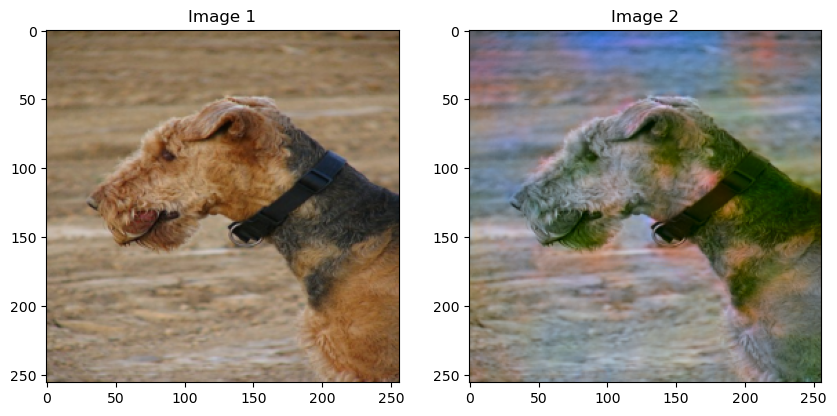

In [10]:
visualize(list(train_dataset)[17]['image'],model)

torch.Size([3, 256, 256])
torch.Size([2, 256, 256])
L shape torch.Size([256, 256])


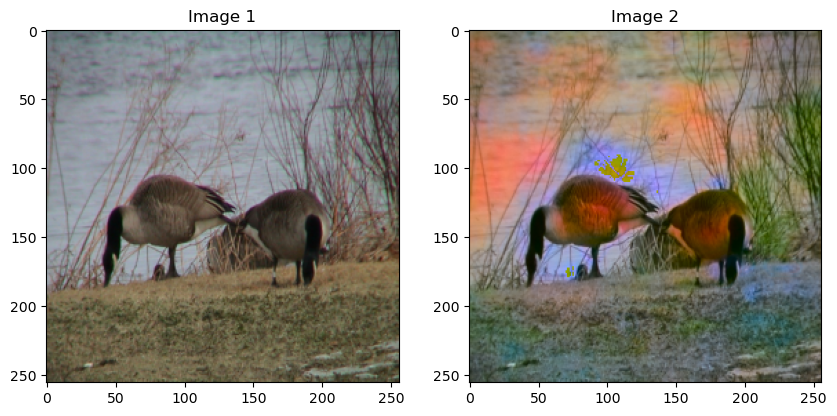

In [11]:
visualize(list(train_dataset)[27]['image'],model)

torch.Size([3, 256, 256])
torch.Size([2, 256, 256])
L shape torch.Size([256, 256])


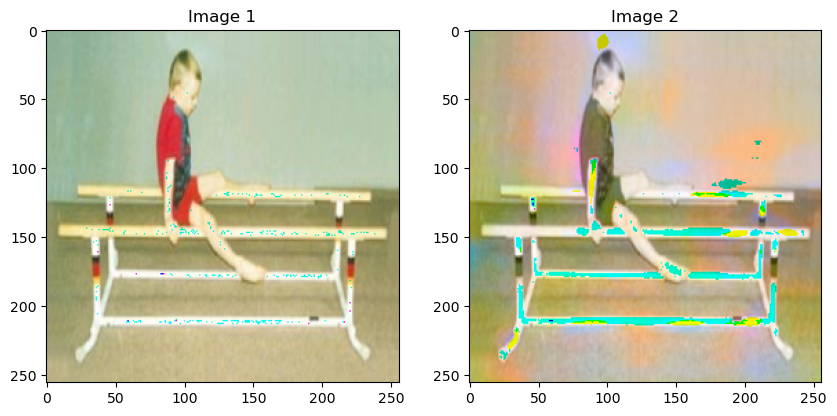

In [12]:
visualize(list(train_dataset)[8]['image'],model)